In [1]:
import msprime
import tskit
import itertools
import random
import math
import numpy as np
from IPython.display import display, SVG

In [2]:
def truncate_ts_samples(ts, average_span, random_seed, min_span=5):
    """
    Create a tree sequence that has sample nodes which have been truncated
    so that they span only a small region of the genome. The length of the
    truncated spans is given by a poisson distribution whose mean is average_span
    but which cannot go below a fixed min_span, or above the sequence_length

    Samples are truncated by removing the edges that connect them to the rest
    of the tree.
    """
    def keep_with_offset(keep, data, offset):
       """Copied from keep_intervals"""
       # We need the astype here for 32 bit machines
       lens = np.diff(offset).astype(np.int32)
       return (data[np.repeat(keep, lens)],
               np.concatenate([
                   np.array([0], dtype=offset.dtype),
                   np.cumsum(lens[keep], dtype=offset.dtype)]))
    np.random.seed(random_seed)
    to_slice = {}
    # for simplicity, we pick lengths from a poisson distribution of av 300 bp
    span = np.random.poisson(average_span, ts.num_samples)
    span = np.maximum(span, min_span)
    span = np.minimum(span, ts.sequence_length)
    start = np.random.uniform(0, ts.sequence_length-span)
    to_slice = {id:(a,b) for id, a, b in zip(ts.samples(), start, start+span)}

    tables = ts.dump_tables()
    tables.edges.clear()
    for e in ts.tables.edges:
        if e.child not in to_slice:
            left, right = e.left, e.right
        else:
            if e.right <= to_slice[e.child][0] or e.left >= to_slice[e.child][1]:
                continue  # this edge is outside the focal region
            else:
                left = max(e.left, to_slice[e.child][0])
                right = min(e.right, to_slice[e.child][1])
        tables.edges.add_row(left, right, e.parent, e.child)
    # Remove mutations above isolated nodes
    print(to_slice)
    mutations = tables.mutations
    keep_mutations = np.ones((mutations.num_rows,), dtype = bool)
    positions = tables.sites.position[:]
    for i, m in enumerate(mutations):
        if m.node in to_slice:
            if not to_slice[m.node][0] <= positions[m.site] < to_slice[m.node][1]:
                keep_mutations[i] = False
    new_ds, new_ds_offset = keep_with_offset(
        keep_mutations, mutations.derived_state, mutations.derived_state_offset)
    new_md, new_md_offset = keep_with_offset(
        keep_mutations, mutations.metadata, mutations.metadata_offset)
    mutations_map = np.append(np.cumsum(keep_mutations) - 1, [-1])
    mutations_map = mutations_map.astype(mutations.parent.dtype)
    # parent -1 always maps to parent -1
    tables.mutations.set_columns(
        site=mutations.site[keep_mutations],
        node=mutations.node[keep_mutations],
        derived_state=new_ds,
        derived_state_offset=new_ds_offset,
        parent=mutations_map[mutations.parent[keep_mutations]],
        metadata=new_md,
        metadata_offset=new_md_offset)
    return tables.tree_sequence()

ts = msprime.simulate(10, Ne=1e2, length=400, recombination_rate=1e-4, mutation_rate=2e-4, random_seed=1)
truncated_ts = truncate_ts_samples(ts, average_span=200, random_seed=123)

{0: (139.09542237324197, 347.09542237324195), 1: (129.53698426364758, 317.5369842636476), 2: (137.98668607091233, 346.98668607091236), 3: (64.91474168448882, 263.91474168448883), 4: (74.89025171381903, 267.890251713819), 5: (46.33743586842799, 243.33743586842797), 6: (59.91766546332119, 255.91766546332119), 7: (135.65986662871487, 320.6598666287149), 8: (18.32888304906996, 219.32888304906996), 9: (84.571728672508, 289.571728672508)}


In [3]:
# Construct a tree sequence with integerized breakpoints
length = 100
recomb_map = msprime.RecombinationMap.uniform_map(length, rate=0.05, num_loci=length)
ts = msprime.simulate(8, mutation_rate=0.1, recombination_map=recomb_map, random_seed=123)

null_char = b"\0"
states = np.array(['a','t','g','c'], dtype='|S1')

tables = ts.dump_tables()
tables.sites.clear()
tables.mutations.clear()
variable_sites = itertools.groupby(ts.sites(), lambda x: math.floor(x.position))
variant_pos, sites_at_vpos = next(variable_sites)

for pos in range(length):
  ancestral_state = random.choice(states)
  site_id = tables.sites.add_row(pos, ancestral_state)
  if variant_pos == pos:
      # Order mutations by time
      mutations = []
      for site in sites_at_vpos:
        mutations.extend(site.mutations)
      mutations.sort(key = lambda x: ts.node(x.node).time, reverse=True)
      for m in mutations:
        # Assign mutations with null parents & derived_states (will be filled in later)
        tables.mutations.add_row(site_id, m.node, derived_state=null_char, parent=tskit.NULL)
      try:
        variant_pos, sites_at_vpos = next(variable_sites)
      except StopIteration:
        variant_pos, sites_at_vpos = -1, []
# Assign parents
tables.compute_mutation_parents()

# Assign derived states (use an array of chars)
ancestral_states = tables.sites.ancestral_state.view(dtype='|S1')
mutation_derived_state = np.full(tables.mutations.num_rows, null_char, dtype='|S1')
for i, m in enumerate(tables.mutations):
    if m.parent == tskit.NULL:
        prev_state = ancestral_states[m.site]
    else:
        prev_state = mutation_derived_state[m.parent]
    # Pick a new state that is different from the old one
    new_state = random.choice([s for s in states if s != prev_state])
    mutation_derived_state[i] = new_state

tables.mutations.derived_state = mutation_derived_state.view(tables.mutations.derived_state.dtype)

finite_sites_ts = tables.tree_sequence()

print(finite_sites_ts.sequence_length)

# Try printing them out
for h in finite_sites_ts.haplotypes():
  print(h)

100.0
ctcggagaccgctgcacctgactaccaatcttggcgttattcacagaccgggtcctttatgctctgacccagatccgcctggagaatcgacgaccggcag
ctctgagtgcgctggactgccaccttccacgcttctttgttcccagaccgggtcctttatgctctaaccccggtccgcctggagtgtcgacgaccggcag
atcggagaccgctgcagccaaatcgtaaacttggcgctagtctaggaccgggtcctttatgctctaacccagatccgcccggagaatcgacgaccggcag
atcggagaccgttgcacctgactgccaaacttggcgctagtctaggaccgggtcttttctgctctaacccagattctccttccgaatcgactaaatgcag
ctctgagagcgctggaccccccttcccaagttggcgctagtctaagatcgggtgttgtctgggataacccagattctccttccgaatcaactacaggcag
atcggagaccgttgcacctgactgccaaacgcttctttattcccagaccgggtcctttatgctctaacccagatccgcctgccgaatcgagtacaggcag
atcggagaccgttgcacctgacagccaaacttggcgctagtctagtaccgggtcttttctgctccaaccctgatgggccattagaatgtacgacaggcag
ctctgtgagcgctggaccccccccgtccacgcttctttattcccagaccgggtcgtttatgctctaacccagatccgcctgccgaatcgagtacaggcag


In [4]:
truncated_ts = truncate_ts_samples(finite_sites_ts, average_span=90, random_seed=1234)

{0: (15.456532432247482, 95.45653243224749), 1: (10.591694287633398, 98.5916942876334), 2: (0.7297719678027446, 98.72977196780275), 3: (10.461735033369393, 93.4617350333694), 4: (1.0553373830016717, 87.05533738300167), 5: (1.8441200300098726, 96.84412003000988), 6: (13.063961427755302, 99.0639614277553), 7: (6.513781432265774, 96.51378143226577)}


In [5]:
for m in truncated_ts.mutations():
    if m.parent == tskit.NULL:
        prev_state = truncated_ts.site(m.site).ancestral_state
    else:
        prev_state = truncated_ts.mutation(m.parent).derived_state
    if prev_state == m.derived_state:
        print(m)

In [27]:
for h in truncated_ts.haplotypes():
    print(h)

non_biallelic = []
print("Variants with more than 2 non-null alleles")
for v in truncated_ts.variants():
    if len(set(v.alleles) - set([None]))>2:
        print(v, "\n")
        non_biallelic.append(v.position)

----------------cctgactaccaatcttggcgttattcacagaccgggtcctttatgctctgacccagatccgcctggagaatcgacgaccg----
-----------ctggactgccaccttccacgcttctttgttcccagaccgggtcctttatgctctaaccccggtccgcctggagtgtcgacgaccggca-
-tcggagaccgctgcagccaaatcgtaaacttggcgctagtctaggaccgggtcctttatgctctaacccagatccgcccggagaatcgacgaccggca-
-----------ttgcacctgactgccaaacttggcgctagtctaggaccgggtcttttctgctctaacccagattctccttccgaatcgactaa------
--ctgagagcgctggaccccccttcccaagttggcgctagtctaagatcgggtgttgtctgggataacccagattctccttccgaatc------------
--cggagaccgttgcacctgactgccaaacgcttctttattcccagaccgggtcctttatgctctaacccagatccgcctgccgaatcgagtacagg---
--------------cacctgacagccaaacttggcgctagtctagtaccgggtcttttctgctccaaccctgatgggccattagaatgtacgacaggcag
-------agcgctggaccccccccgtccacgcttctttattcccagaccgggtcgtttatgctctaacccagatccgcctgccgaatcgagtacagg---
Variants with more than 2 non-null alleles
{'site': {'id': 8, 'position': 8.0, 'ancestral_state': 'c', 'mutations': [{'id': 2, 'site': 8, 'node': 21, 'derived_state': 'a', 'parent': -1, 'metad

In [28]:
import tsinfer

In [29]:
sample_data = tsinfer.SampleData.from_tree_sequence(truncated_ts)

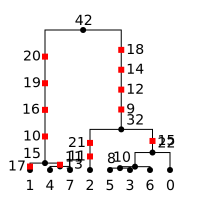

In [30]:
display(SVG(truncated_ts.at(16).draw_svg()))

In [35]:
# which sites are set for inference
non_biallelic_indexes = np.isin(sample_data.sites_position, np.array(non_biallelic))
for i in np.where(non_biallelic_indexes)[0]:
    print("Site at position {}: Inference: {}".format(
        sample_data.sites_position[i], sample_data.sites_inference[i]))

Site at position 8.0: Inference: 1
Site at position 14.0: Inference: 0
Site at position 16.0: Inference: 0
Site at position 18.0: Inference: 0
Site at position 19.0: Inference: 0
Site at position 20.0: Inference: 1
Site at position 21.0: Inference: 0
Site at position 22.0: Inference: 1
Site at position 23.0: Inference: 1
Site at position 24.0: Inference: 1
Site at position 25.0: Inference: 0
Site at position 31.0: Inference: 1
Site at position 33.0: Inference: 0
Site at position 36.0: Inference: 0
Site at position 42.0: Inference: 1
Site at position 53.0: Inference: 0
Site at position 54.0: Inference: 1
Site at position 70.0: Inference: 1
Site at position 74.0: Inference: 1
Site at position 79.0: Inference: 1
Site at position 81.0: Inference: 1
Site at position 82.0: Inference: 1


In [26]:
np.array(non_biallelic)

array({8.0, 14.0, 16.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 31.0, 33.0, 36.0, 42.0, 53.0, 54.0, 70.0, 74.0, 79.0, 81.0, 82.0},
      dtype=object)

In [11]:
tsinfer.infer(sample_data, engine="P")

IndexError: tuple index out of range